In [1]:
from typing import Callable

import re
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_distribution(map_id: str, include_rtss: bool=False, upper_bound: float=None, plot_box: bool=False):
    map2_evals = {f.split(os.path.sep)[-2]: np.load(f) for f in glob.glob(f"logs/{map_id}/*/performance.npy")}
    map1_evals = {}
    if include_rtss:
        map1_evals = {f.split(os.path.sep)[-2]: np.load(f) for f in glob.glob(f"logs/rtss_{map_id}/*/performance.npy") if "bot" not in f}
    map2_evals = {k.strip('_')  : v for k, v in map2_evals.items() if (not k[-1].isdigit()) and ("rgb" not in k or "rgb_9e-4" in k or "ss_rgb" in k)}
    map1_evals = {k.strip('_')  : v for k, v in map1_evals.items() if (not k[-1].isdigit()) and ("rgb" not in k or "rgb_9e-4" in k or "ss_rgb" in k)}
    lower_bound = 0
    if upper_bound is None:
        upper_bound = max([v.max() for v in map2_evals.values()]) + 10
    num_models = len(map2_evals) + len(map1_evals)
    extract_model_type = re.compile(f"(.*)map{map_id}_((?:ss)?_?(?:rgb)?)_[0-9]+e-[0-9]+")
    best_models = {"bot" : (f"map{map_id}_bot", None)}
    for k, data in map2_evals.items():
        model_type = extract_model_type.match(k)
        if model_type is None:
            # print(k)
            continue
        model_type = model_type.group(1) + model_type.group(2)
        data_mean = data.mean()
        if not (model_type in best_models and data_mean <= best_models[model_type][1]):
            if "rtss" not in model_type:
                best_models[model_type] = (k, data_mean)
                if model_type != "rgb":
                    best_models["rtss_"+model_type] = ("rtss_" + k, data_mean)

    tmp = [("bot", map2_evals["bot"])] 
    del map2_evals["bot"]

    map2_evals_best = map2_evals #{k : map2_evals[k] for k, _ in best_models.values()}
    map2_evals_best.update({
        k + " (RT)" : v for k, v in map1_evals.items()
    })
    tmp += sorted(sorted(map2_evals_best.items(), key=lambda x: x[1].mean()), key=lambda x: np.median(x[1]))
    if plot_box:
        datas = []
        labels = []
        for i, (k, data) in enumerate(tmp, 1):
            datas.append(data)
            labels.append(f"{k.replace("ppo_", '').replace("_final", '')} ({data.mean():.1f})")
        plt.grid()
        plt.xlim(lower_bound, upper_bound)
        return plt.boxplot(datas, vert=False, patch_artist=True, meanline=True, tick_labels=labels)
    else:
        for i, (k, data) in enumerate(tmp, 1):
            # print(data)
            plt.subplot(num_models, 1, i)
            if i == 1:
                plt.title(f"{map_id.upper().replace('_', ' ')}")
            Q1, Q2, Q3 = [int(np.percentile(data, 25 * i)) for i in (1, 2, 3)]
            min_, max_, mean_ = int(data.min()), int(data.max()), data.mean()
            plt.hist(data, np.arange(upper_bound), label=f"{k.replace("ppo_", '').replace("_final", '')} ({mean_:.1f})")
            plt.xticks(np.arange(0, upper_bound, 5)+0.5, [str(i) for i in range(0, upper_bound, 5)], fontsize=8)
            ylim = 1500 if "bot" in k else 150
            plt.plot([Q1+0.5, Q1+0.5], [0, ylim], 'y', linewidth=3)#, label=f"Q1={Q1:2d} (min={min_ :2d})")
            plt.plot([Q2+0.5, Q2+0.5], [0, ylim], 'b', linewidth=3)#, label=f"Q2={Q2:2d} (avg={mean_:.2f})")
            plt.plot([Q3+0.5, Q3+0.5], [0, ylim], 'r', linewidth=3)#, label=f"Q3={Q3:2d} (max={max_ :2d})")
            plt.legend(fontsize=8, loc="upper right")
            plt.ylim(lower_bound, ylim)
            plt.xlim(0, upper_bound)

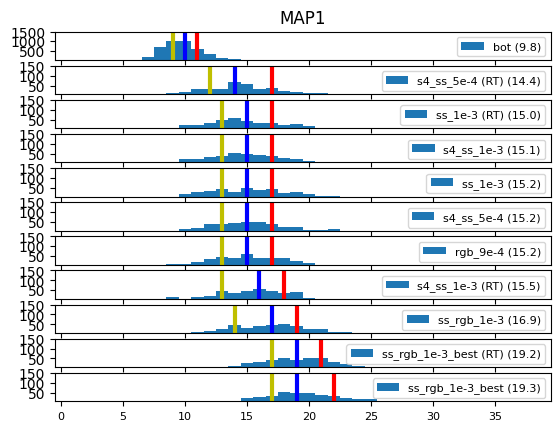

In [3]:
plot_distribution("map1", True, 40)

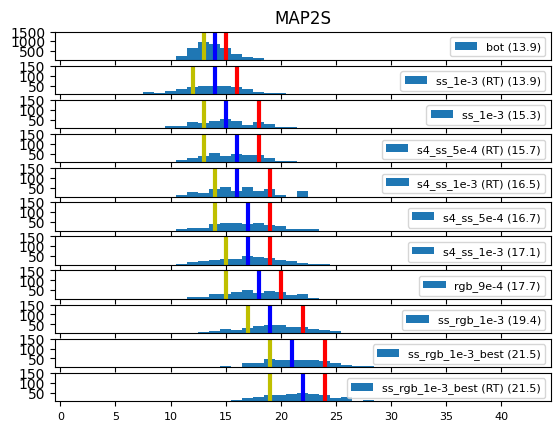

In [4]:
plot_distribution("map2s", True, 45)

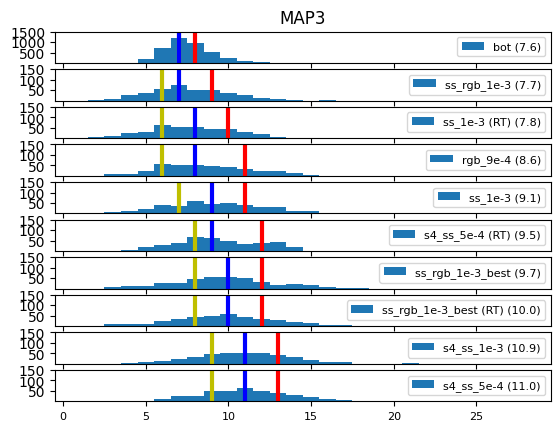

In [5]:
plot_distribution("map3", True, 30)

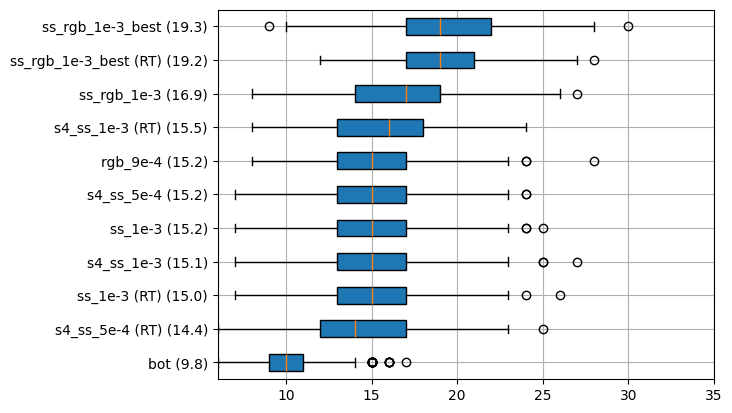

In [6]:
plot_distribution("map1", True, 35, plot_box=True);

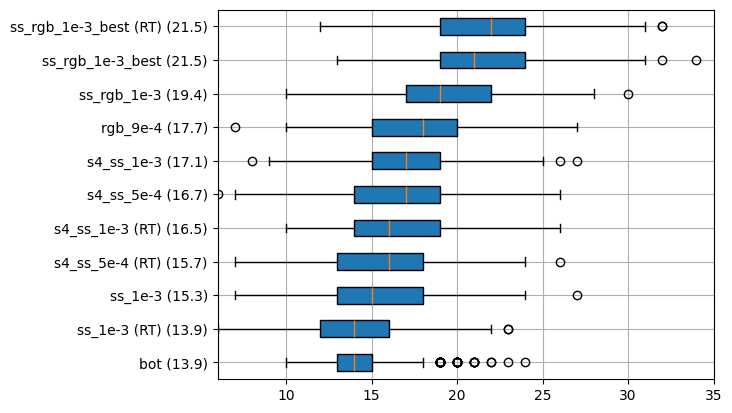

In [7]:
plot_distribution("map2s", True, 35, plot_box=True);

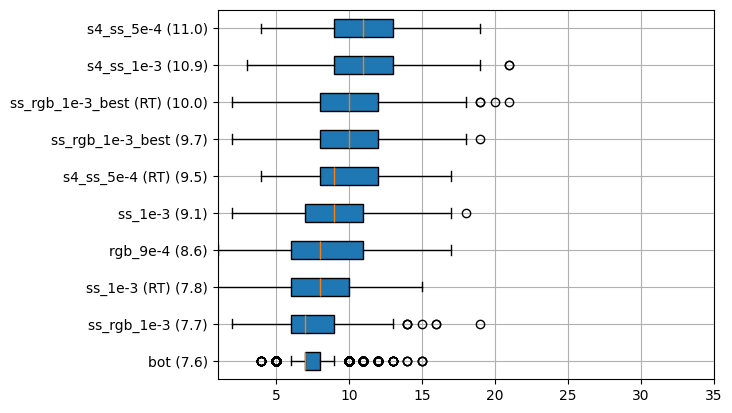

In [8]:
plot_distribution("map3", True, 35, plot_box=True);